### Image classification Using VGG-16

#### Dataset - CIFAR10   https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt


2. Load and Transform the Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


3. Define the VGG16 Model

In [4]:
vgg16 = models.vgg16(pretrained=False)  # Initialize VGG16 without pretrained weights

# Modify the classifier
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]  # Remove last layer
features.extend([nn.Linear(num_features, len(trainset.classes))])  # Add our layer with desired output units
vgg16.classifier = nn.Sequential(*features)  # Replace the model classifier

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)


D:\pytorch_for_deep_learning\myvenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\pytorch_for_deep_learning\myvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


4. Define Loss Function and Optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)


5. Train the Model

In [6]:
num_epochs = 10
# Initialize lists to store loss and accuracy of each epoch
losses = []
accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0  # to track the number of correct predictions
    total = 0  # to track the total number of predictions

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    losses.append(epoch_loss)  # Append the average loss for this epoch to the list
    accuracies.append(epoch_accuracy)  # Append the accuracy for this epoch to the list

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%")



Epoch 1/10, Loss: 1.8283818555198568, Accuracy: 32.448%
Epoch 2/10, Loss: 1.4067806571779233, Accuracy: 49.07%
Epoch 3/10, Loss: 1.1799289249336575, Accuracy: 57.692%
Epoch 4/10, Loss: 0.9805954912878807, Accuracy: 65.288%
Epoch 5/10, Loss: 0.8267903127734354, Accuracy: 71.06%
Epoch 6/10, Loss: 0.6996840541742585, Accuracy: 75.226%
Epoch 7/10, Loss: 0.5970812816022683, Accuracy: 79.1%
Epoch 8/10, Loss: 0.49711282732905443, Accuracy: 82.61%
Epoch 9/10, Loss: 0.41104452833008936, Accuracy: 85.486%
Epoch 10/10, Loss: 0.330412721195838, Accuracy: 88.366%


6. Save the Model

In [7]:
torch.save(vgg16.state_dict(), './vgg16_cifar10_without_transferlearning.pth')


7. Plot Training Loss and Accuracy

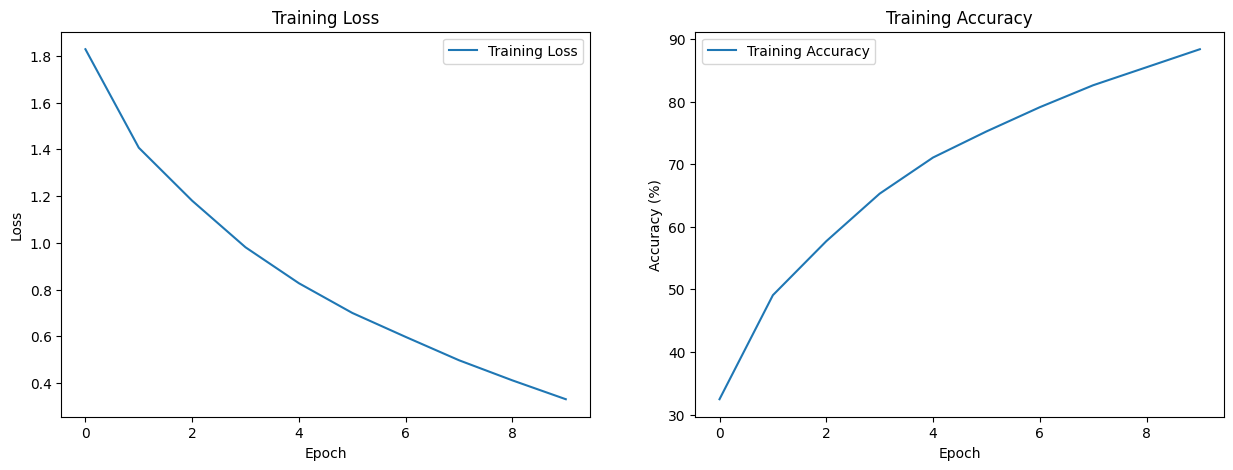

In [8]:
import matplotlib.pyplot as plt

# Assuming `losses` and `accuracies` are lists containing loss and accuracy values for each epoch

# Set up a figure with two subplots
plt.figure(figsize=(15, 5))

# Plot for training loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(losses, label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot for training accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(accuracies, label='Training Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Display the plots
plt.show()


8. Confusion Matrix

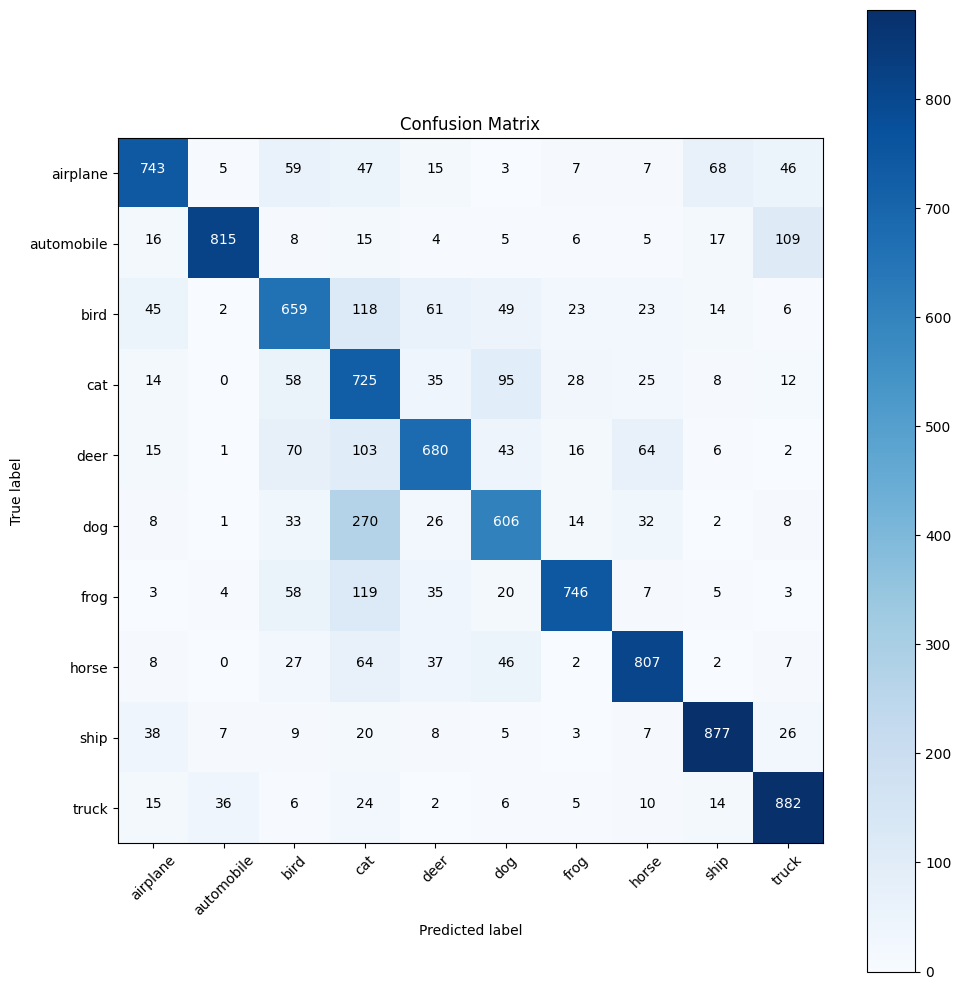

In [9]:
# Get predictions and true labels
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(trainset.classes))
plt.xticks(tick_marks, trainset.classes, rotation=45)
plt.yticks(tick_marks, trainset.classes)

# Loop over data to plot text
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


9. Load the Model

In [10]:
# model = models.vgg16()  # Initialize the model
# model.load_state_dict(torch.load('./vgg16_cifar10_without_transferlearning.pth'))
# model = model.to(device)



model = models.vgg16(pretrained=False)  # Initialize VGG16 without pretrained weights

# Modify the classifier to match the saved model
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]  # Remove last layer
features.extend([nn.Linear(num_features, 10)])  # Adapt to your dataset, CIFAR10 has 10 classes
model.classifier = nn.Sequential(*features)

# Load the state dict (model weights)
model.load_state_dict(torch.load('./vgg16_cifar10_without_transferlearning.pth'))

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

D:\pytorch_for_deep_learning\myvenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\pytorch_for_deep_learning\myvenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


10. Test the Model on Unseen Dataset

In [11]:
from PIL import Image
import torchvision.transforms as transforms

# 1. Load the image
image_path = 'test2.jpg'  # Change this to the path of your image
image = Image.open(image_path)

# 2. Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize it
])
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# 3. Put the model in evaluation mode
model.eval()

# 4. Make a prediction
with torch.no_grad():
    # Move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_image = input_image.to('cuda')
        model.to('cuda')
    
    output = model(input_image)

# 5. Interpret the output
_, predicted = torch.max(output, 1)  # Get the index of the highest log-probability

# Get the class label (modify this part according to your dataset classes)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  # Replace with your own class labels
predicted_class = class_labels[predicted.item()]

print("Predicted Class: ", predicted_class)


Predicted Class:  truck
